In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.utils import resample
import statsmodels.api as sm
from tqdm import tqdm

In [2]:
data = pd.read_excel('Test project (activations forecast).xlsx', sheet_name='data')

In [3]:
# обработка дат
date_cols = ['APPLICATION_DATE', 'AGREEMENT_DATE', 'UTILIZATION_DATE']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [4]:
train_date_end = pd.Timestamp('2023-06-15')
forecast_end = pd.Timestamp('2023-07-31')

In [31]:
# рассчет вероятности получения соглашения (с учетом кол-ва клиентов)
total_clients = data['CNT'].sum()
clients_with_agreement = data[data['AGREEMENT_DATE'].notna()]['CNT'].sum()
p_agreement = clients_with_agreement / total_clients
total_clients, p_agreement

(14675, 0.4904258943781942)

In [6]:
# создаем распределения с учетом кол-ва клиентов
agreement_delays = []
utilization_delays = []

for _, row in data.iterrows():
    # распределение заявка -> соглашение
    if pd.notnull(row['AGREEMENT_DATE']) and pd.notnull(row['APPLICATION_DATE']):
        delay = (row['AGREEMENT_DATE'] - row['APPLICATION_DATE']).days
        if delay > 0:
            agreement_delays.extend([delay] * int(row['CNT']))
    
    # распределение соглашение -> утилизация
    if pd.notnull(row['UTILIZATION_DATE']) and pd.notnull(row['AGREEMENT_DATE']):
        delay = (row['UTILIZATION_DATE'] - row['AGREEMENT_DATE']).days
        if delay >= 0:
            utilization_delays.extend([delay] * int(row['CNT']))

In [33]:
np.mean(agreement_delays), np.mean(utilization_delays)

(5.555144793592113, 2.46205472379969)

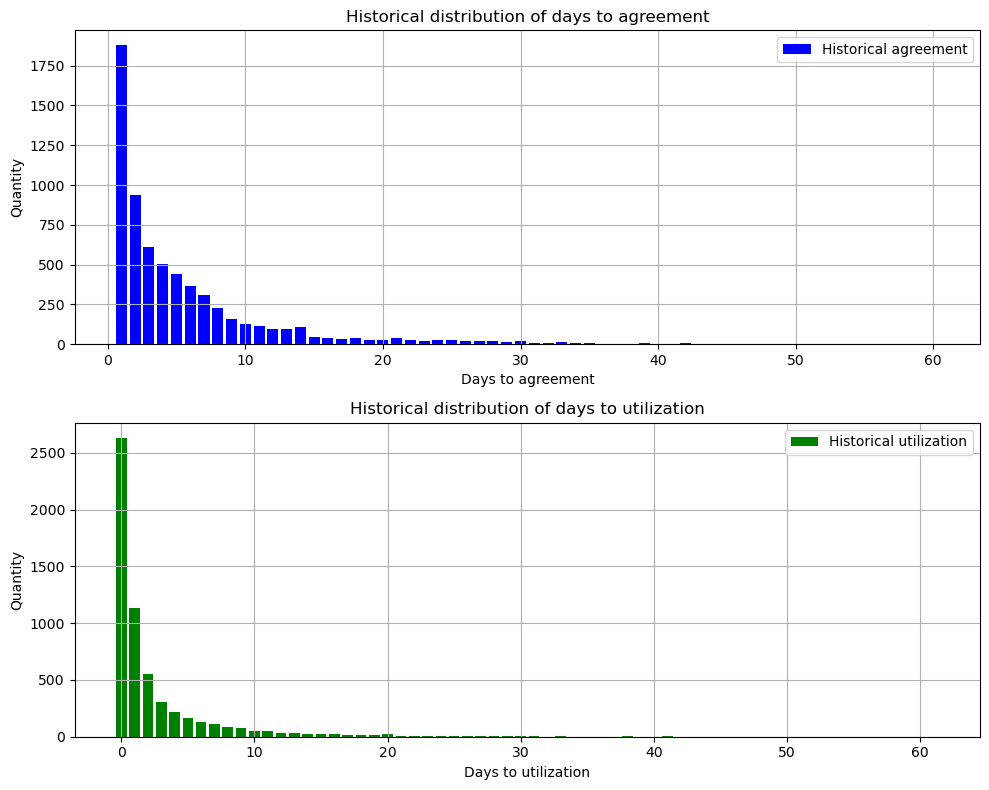

In [30]:
hist_agreement_aggregetion = pd.Series(agreement_delays).value_counts()
hist_util_aggregetion = pd.Series(utilization_delays).value_counts()

plt.figure(figsize=(10, 8))


plt.subplot(2, 1, 1)
plt.bar(hist_agreement_aggregetion.index, hist_agreement_aggregetion.values, label='Historical аgreement', color='blue')
plt.title('Historical distribution of days to аgreement')
plt.xlabel('Days to аgreement')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(hist_util_aggregetion.index, hist_util_aggregetion.values, label='Historical utilization', color='green')
plt.title('Historical distribution of days to utilization')
plt.xlabel('Days to utilization')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

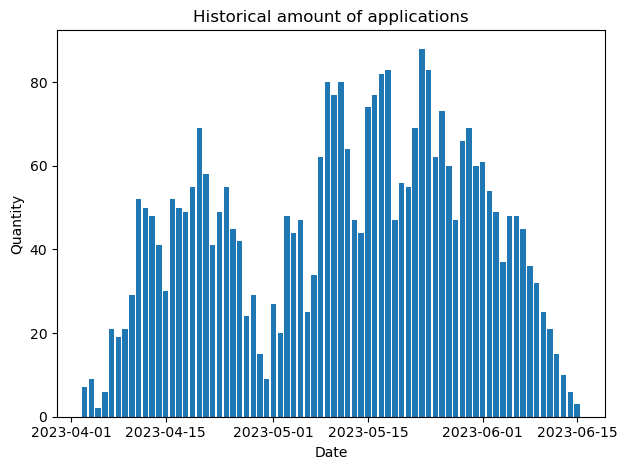

In [29]:
df_group = data.copy()
x_column_name = 'APPLICATION_DATE'
col_names = [x_column_name, 'CNT']
df_group = df_group[col_names].groupby(by=x_column_name, as_index=False).count().sort_values(by=x_column_name).reset_index(drop=True)

plt.bar(df_group[x_column_name], df_group['CNT'])
plt.title('Historical amount of applications')
plt.xlabel('Date')
plt.ylabel('Quantity')

plt.tight_layout()
plt.show()

In [7]:
# прогноз новых заявок
def forecast_new_applications(start_date, end_date, historical_data):
    # Агрегируем исторические данные по дням
    historical = historical_data.groupby(historical_data['APPLICATION_DATE'].dt.date)['CNT'].sum()
    historical = historical.reindex(pd.date_range(historical.index.min(), historical.index.max()), fill_value=0)
    daily_mean = historical.mean()
    # сезонная ARIMA
    try:
        model = sm.tsa.SARIMAX(historical, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=(end_date - start_date).days)
        pred = forecast.predicted_mean
        
    except:
        # используем историческое среднее (если нарушается стационарность)
        daily_mean = historical.mean()
        pred = pd.Series([daily_mean] * (end_date - start_date).days)
    
    # Генерация новых заявок
    new_apps = []
    current_date = start_date
    for i, date in enumerate(pd.date_range(start_date, end_date)):
        # Предсказанное значение + случайные колебания
        n_apps = max(0, int(pred.iloc[i] if i < len(pred) else daily_mean))
        n_apps = np.random.poisson(lam=n_apps, size=1)[0]
        
        if n_apps > 0:
            new_apps.append({
                'APPLICATION_DATE': date,
                'AGREEMENT_DATE': pd.NaT,
                'UTILIZATION_DATE': pd.NaT,
                'CNT': n_apps
            })
    
    return pd.DataFrame(new_apps)

In [13]:
def bootstrap_forecast(n_iter=500):
    forecasts = []
    for i in tqdm(range(n_iter)):
        given_data = data.copy()
        
        # прогноз новых заявок (с 2023-06-16 до 2023-07-31)
        new_apps = forecast_new_applications(
            start_date=train_date_end + timedelta(days=1),
            end_date=forecast_end,
            historical_data=data
        )
        given_data = pd.concat([given_data, new_apps], ignore_index=True)
        
        # прогноз соглашений для всех клиентов без соглашения
        no_agreement = given_data[given_data['AGREEMENT_DATE'].isna()].copy()
        new_agreements = []
        
        for _, row in no_agreement.iterrows():
            n_clients = row['CNT']
            n_agreements = np.random.binomial(n_clients, p_agreement)
            
            if n_agreements > 0:
                delays = resample(agreement_delays, n_samples=n_agreements, replace=True)
                app_date = row['APPLICATION_DATE']
                
                for delay in delays:
                    agreement_date = app_date + timedelta(days=int(delay))
                    if agreement_date <= forecast_end:
                        new_agreements.append({
                            'APPLICATION_DATE': app_date,
                            'AGREEMENT_DATE': agreement_date,
                            'CNT': 1
                        })
        
        # прогноз утилизаций
        # исторические клиенты с соглашением без утилизации
        historical = given_data[
            (given_data['AGREEMENT_DATE'].notna()) & 
            (given_data['UTILIZATION_DATE'].isna())
        ].copy()
        
        # новые соглашения
        if len(new_agreements) == 0:
            new_agreements_df = pd.DataFrame()
        else:
            new_agreements_df = pd.DataFrame(new_agreements)
        
        # все клиенты с соглашением без утилизации
        all_agreements = pd.concat([historical, new_agreements_df], ignore_index=True)
        
        # 4. генерация утилизациц
        utilizations = []
        for _, row in all_agreements.iterrows():
            n_clients = row['CNT']
            delays = resample(utilization_delays, n_samples=n_clients, replace=True)
            agreement_date = row['AGREEMENT_DATE']
            
            for delay in delays:
                util_date = agreement_date + timedelta(days=int(delay))
                if train_date_end < util_date <= forecast_end:
                    utilizations.append(util_date.date())
        
        # группировка по дням из прогноза
        util_counts = pd.Series(utilizations).value_counts()
        date_range = pd.date_range(train_date_end + timedelta(days=1), forecast_end)
        full_counts = util_counts.reindex(date_range.date, fill_value=0)
        forecasts.append(full_counts)
    
    # Объединение результатов
    forecast_df = pd.concat(forecasts, axis=1)
    forecast_df.index = date_range
    return forecast_df

In [17]:
# вызов основной функции прогноза утилизаций
bootstrap_results = bootstrap_forecast(n_iter=500)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\firso\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\firso\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
  0%|▏                                                                                 | 1/500 [00:03<30:41,  3.69s/it]C:\Users\firso\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\firso\anaco

In [16]:
# Расчет метрик
daily_mean = bootstrap_results.mean(axis=1)
daily_lower = bootstrap_results.quantile(0.025, axis=1)
daily_upper = bootstrap_results.quantile(0.975, axis=1)
cumulative = bootstrap_results.cumsum(axis=0)

cumulative_mean = cumulative.mean(axis=1)
cumulative_lower = np.percentile(cumulative, 2.5, axis=1)
cumulative_upper = np.percentile(cumulative, 97.5, axis=1)

# dttm_names = pd.Series(daily_mean.index)
# date_names = dttm_names.dt.date

# итоговая таблица
result = pd.DataFrame({
    'date': daily_mean.index.date,
    'daily_utilizations': daily_mean,
    'daily_lower_ci': daily_lower,
    'daily_upper_ci': daily_upper,
    'cumulative_utilizations': cumulative_mean,
    'cumulative_lower_ci': cumulative_lower,
    'cumulative_upper_ci': cumulative_upper
})
result.to_excel('forecast solution.xlsx', index=False)
result

,date,daily_utilizations,daily_lower_ci,daily_upper_ci,cumulative_utilizations,cumulative_lower_ci,cumulative_upper_ci
2023-06-16,2023-06-16,180.0,164.9,191.9,180.0,164.9,191.9
2023-06-17,2023-06-17,174.0,162.6,188.8,354.0,342.6,363.9
2023-06-18,2023-06-18,171.0,158.8,180.6,525.0,507.3,540.5
2023-06-19,2023-06-19,169.8,152.4,187.8,694.8,659.7,728.1
2023-06-20,2023-06-20,186.4,159.4,207.3,881.2,832.7,914.7
2023-06-21,2023-06-21,190.2,172.2,207.7,1071.4,1035.6,1105.4
2023-06-22,2023-06-22,192.0,180.8,203.2,1263.4,1231.2,1295.0
2023-06-23,2023-06-23,213.6,195.1,246.7,1477.0,1430.0,1541.0
2023-06-24,2023-06-24,195.0,182.1,202.7,1672.0,1629.2,1740.2
2023-06-25,2023-06-25,210.2,205.3,218.2,1882.2,1837.5,1947.9


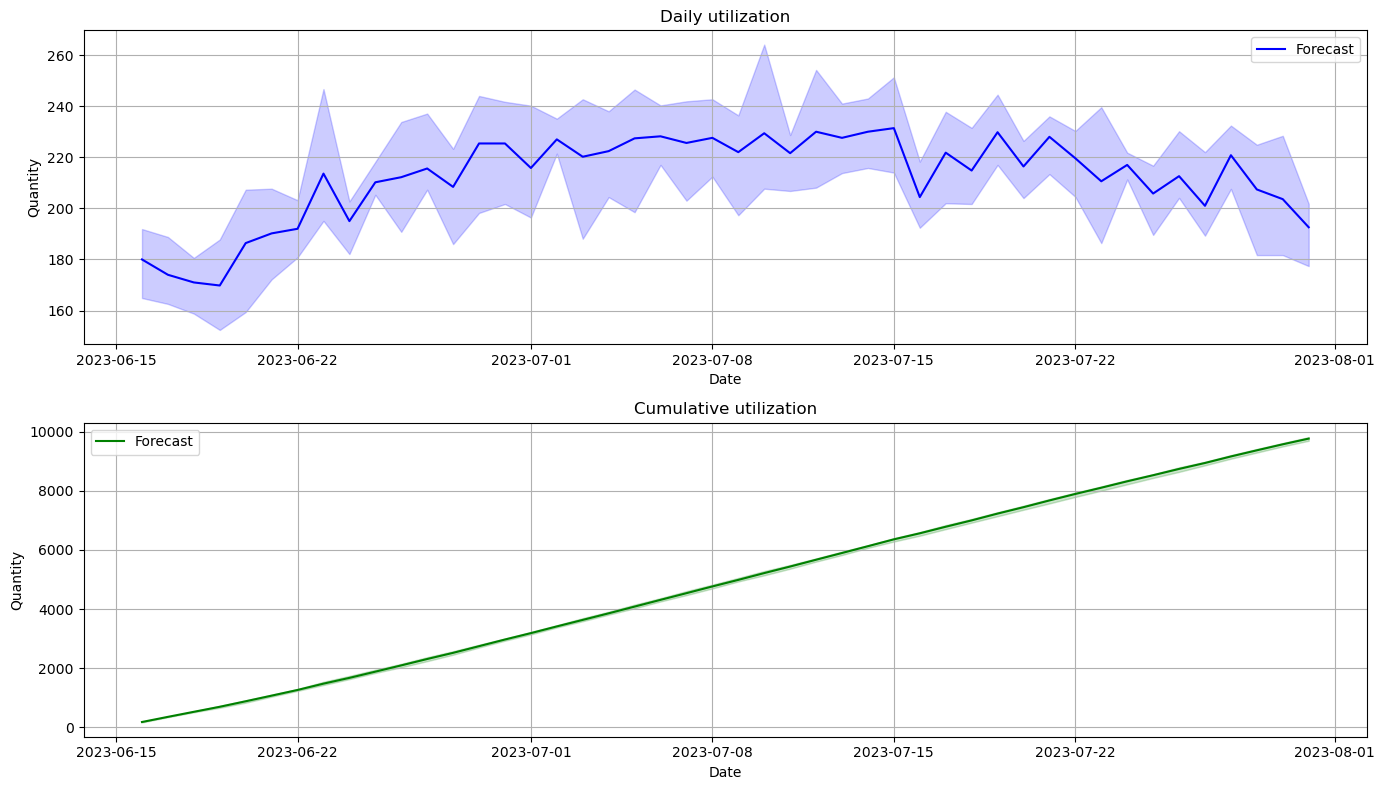

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

date_range = bootstrap_results.index

plt.figure(figsize=(14, 8))

# График ежедневных утилизаций
plt.subplot(2, 1, 1)
plt.plot(date_range, daily_mean, label='Forecast', color='blue')
plt.fill_between(date_range, daily_lower, daily_upper, alpha=0.2, color='blue')
plt.title('Daily utilization')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

# График кумулятивных утилизаций
plt.subplot(2, 1, 2)
plt.plot(date_range, cumulative_mean, label='Forecast', color='green')
plt.fill_between(date_range, cumulative_lower, cumulative_upper, alpha=0.2, color='green')
plt.title('Cumulative utilization')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
result.describe()

,daily_utilizations,daily_lower_ci,daily_upper_ci,cumulative_utilizations,cumulative_lower_ci,cumulative_upper_ci
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,212.208696,195.356522,228.336957,4894.030435,4830.463043,4941.900000
std,16.857307,17.233567,18.761928,2932.744959,2912.436926,2935.715152
min,169.800000,152.400000,180.600000,180.000000,164.900000,191.900000
25%,204.750000,186.100000,219.175000,2362.100000,2290.925000,2423.200000
50%,216.100000,200.100000,233.100000,4874.400000,4812.300000,4939.400000
75%,225.550000,207.525000,241.525000,7388.500000,7299.575000,7438.300000
max,231.400000,221.400000,264.100000,9761.600000,9687.300000,9812.300000
